## Import Modules

In [1]:
# Core
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from pyclustering.cluster.kmedoids import kmedoids


# Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import wordcloud
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk.collocations as nc
import spacy
nlp = spacy.load('en_core_web_sm')
# Remove stopwords, including google and tesla
stops = stopwords.words('english') + ['google', 'tesla', 'work']
en_stopwords = set(stops)
from textblob import TextBlob
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Time Series
import seaborn as sns
sns.set(style="ticks", color_codes=True)

# Geo
import folium
import os


## Import Datasets 
#### (Google & Tesla reviews web-scraped from Indeed)

In [22]:
# Import datasets - web scraped data

# Code Source 
# https://stackoverflow.com/questions/16888888/how-to-read-a-xlsx-file-
# using-the-pandas-library-in-ipython

df_google = pd.read_excel('google_reviews.xlsx', sheet_name="sheet1")
df_tesla = pd.read_excel('tesla_reviews.xlsx', sheet_name="sheet1")

# Import state data for geo

# Code Source 
# https://developers.google.com/public-data/docs/canonical/states_csv
df_state_geo = pd.read_csv('states_geo.csv')

## EDA & Data Cleaning

In [23]:
# Get some information about the datasets

# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_google.info()
df_tesla.info()

# No missing values - all objects, one float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 6 columns):
title       1326 non-null object
reviewer    1329 non-null object
location    1329 non-null object
date        1329 non-null object
rating      1329 non-null float64
reviews     1329 non-null object
dtypes: float64(1), object(5)
memory usage: 62.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 6 columns):
title       1233 non-null object
reviewer    1235 non-null object
location    1235 non-null object
date        1235 non-null object
rating      1235 non-null float64
reviews     1235 non-null object
dtypes: float64(1), object(5)
memory usage: 58.0+ KB


####  Convert data types

In [24]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Date to date data type
df_google.date = pd.to_datetime(df_google.date)
df_tesla.date = pd.to_datetime(df_tesla.date)

# Rating to integer
df_google.rating = df_google.rating.astype(np.int64)
df_tesla.rating = df_tesla.rating.astype(np.int64)

In [25]:
# Take a look at the google dataframe
df_google.head(2)

,title,reviewer,location,date,rating,reviews
0,Awesome,Camp Counselor (Former Employee) –,"Northborough, MA",2018-01-17,5,Awesome stuff at google if I had to rate it fr...
1,Google is great Bon Apeptit isn’t so great!,Micro kitchen attendant (Former Employee) –,"Mountain View, CA",2018-08-24,5,Google is a great company and the googler were...


In [26]:
# Take a look at the tesla dataframe
df_tesla.head(2)

,title,reviewer,location,date,rating,reviews
0,Stressful,PV Design Engineer II (Current Employee) –,"Westborough, MA",2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...
1,Looks good on the resume,Service Advisor (Former Employee) –,"Burbank, CA",2019-01-16,3,Tesla asks if you're okay with overtime but yo...



#### Create employee type (former or current employee) from reviewer variable

In [27]:
# Strip out former/current employee and make it's own variable

# Code Source: 
# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/

# split reviewer variable on '(' 
new_google = df_google["reviewer"].str.split("(", n = 1, expand = True) 
new_tesla = df_tesla["reviewer"].str.split("(", n = 1, expand = True) 

# make job title column from the left part of the split 
df_google["job_title"]= new_google[0] 
df_tesla["job_title"]= new_tesla[0] 
  
# make emp type column from the right part of the split
df_google["emp_status"]= new_google[1] 
df_tesla["emp_status"]= new_tesla[1] 

# Drop reviewer column 
df_google.drop('reviewer', inplace=True, axis=1)
df_tesla.drop('reviewer', inplace=True, axis=1) 

In [28]:
# Now have 7 variables, created employee type & job title, dropped reviewer
df_google.shape

(1329, 7)

In [29]:
df_tesla.shape

(1235, 7)

In [30]:
# Get a count of each employee status category

# Code Source
# https://stackoverflow.com/questions/22391433/count-the-frequency
# -that-a-value-occurs-in-a-dataframe-column

df_google['emp_status'].value_counts()

# Lots of junk in there

Former Employee) –                                                     826
Current Employee) –                                                    454
Contract) (Former Employee) –                                           12
Contractor) (Former Employee) –                                          6
Contract) (Current Employee) –                                           2
contract) (Current Employee) –                                           2
contractor) (Former Employee) –                                          1
 C) (Former Employee) –                                                  1
temp. contractor) (Former Employee) –                                    1
Adecco Temporary), Driver/Image Collector (Former Employee) –            1
L&D) (Current Employee) –                                                1
UX) Research Operations for Google  Analytics (Former Employee) –        1
Fixed-Term) (Former Employee) –                                          1
ITRP) (Current Employee) 

In [31]:
df_tesla['emp_status'].value_counts()

Former Employee) –                                     728
Current Employee) –                                    490
Temp) (Former Employee) –                                2
Mechanical Joining) (Current Employee) –                 1
Automation) (Former Employee) –                          1
CDL) (Current Employee) –                                1
SEASONAL) (Former Employee) –                            1
PLM) Program Manager (Former Employee) –                 1
Swing Shift) (Former Employee) –                         1
Powertrain Conveyance) (Current Employee) –              1
Production Associate) -Via (Current Employee) –          1
contract) (Former Employee) –                            1
Contract) (Former Employee) –                            1
 Lead-Davie) (Former Employee) –                         1
Production Control /Model 3) (Current Employee) –        1
Supply Chain Programs (Current Employee) –               1
Full-time) (Current Employee) –                         

In [32]:
# Pretty much an if statement - if emp_status contains 'Current', make it 'current', else make it 'former'

# Code Source
# https://stackoverflow.com/questions/18196203/
# how-to-conditionally-update-dataframe-column-in-pandas

df_google['emp_status'] = np.where(df_google['emp_status'].str.contains('Current'), 'current', 'former')

df_tesla['emp_status'] = np.where(df_tesla['emp_status'].str.contains('Current'), 'current', 'former')

In [33]:
# Clean categories - current/former
df_google['emp_status'].value_counts()

former     863
current    466
Name: emp_status, dtype: int64

In [34]:
df_tesla['emp_status'].value_counts()

former     738
current    497
Name: emp_status, dtype: int64

#### Create state from location variable

In [35]:
# Strip out state and make it's own variable

# split location variable on ',' 
new_google = df_google["location"].str.split(",", n = 1, expand = True) 
new_tesla = df_tesla["location"].str.split(",", n = 1, expand = True) 

# make state column from the right part of the split 
df_google["state"]= new_google[1] 
df_tesla["state"]= new_tesla[1] 

# Drop location column 
df_google.drop('location', inplace=True, axis=1)
df_tesla.drop('location', inplace=True, axis=1) 

In [36]:
# Take the first two characters

# Code Source
# https://stackoverflow.com/questions/36505847/substring-of-an-entire-column-in-pandas-dataframe

df_google.state = df_google.state.str.slice(1, 3)
df_tesla.state = df_tesla.state.str.slice(1, 3)

In [37]:
# Upper case the state code extracted

# Code Source
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.upper.html

df_google.state = df_google.state.str.upper()
df_tesla.state = df_tesla.state.str.upper()

In [38]:
# Get a count of each employee status category
df_google['state'].value_counts()

CA    629
NY    117
WA     58
TX     48
GA     41
MI     36
IL     30
MA     26
PA     21
FL     19
AZ     18
NC     16
MO     16
DC     12
CO     12
IA     11
UT      9
OR      9
SC      6
NJ      4
NV      4
NM      4
MD      3
TN      3
AL      3
WI      3
KS      3
ID      3
IN      2
OK      2
        2
OH      2
VA      2
AR      1
CT      1
DA      1
A.      1
E       1
ES      1
NH      1
PR      1
CE      1
A       1
D       1
VT      1
MS      1
AS      1
Name: state, dtype: int64

In [39]:
# Validate states extracted against state list,
# Not found assign ERR

# Code Source
# https://thispointer.com/python-how-to-check-if-an-item-exists-in-list-search-by-value-or-condition/

def state_lookup(df):
    # If valid state code, keep it, else assign 'ERR'
    for i in range(0,len(df)):
        if df.iloc[i] in df_state_geo['state'].values.tolist():
            df[i] = df[i]
        else:
            df[i] = 'ERR'
        

In [40]:
state_lookup(df_google.state)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [41]:
state_lookup(df_tesla.state)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [42]:
# Get a count of reviews in each state
df_google['state'].value_counts()

CA     629
ERR    151
NY     117
WA      58
TX      48
GA      41
MI      36
IL      30
MA      26
PA      21
FL      19
AZ      18
MO      16
NC      16
CO      12
DC      12
IA      11
UT       9
OR       9
SC       6
NM       4
NJ       4
NV       4
WI       3
AL       3
MD       3
ID       3
TN       3
KS       3
IN       2
OK       2
OH       2
VA       2
MS       1
NH       1
PR       1
CT       1
AR       1
VT       1
Name: state, dtype: int64

In [43]:
# Get a count of reviews in each state
df_tesla['state'].value_counts()

CA     784
NV     175
ERR     81
TX      32
NY      20
UT      18
CO      14
FL      12
MD      10
MA       9
NJ       8
PA       8
OH       7
NC       6
DE       5
AZ       5
CT       4
VA       4
WA       4
OR       3
VT       3
GA       3
HI       3
MI       2
NM       2
MN       2
IL       2
OK       1
ID       1
LA       1
KS       1
AK       1
ND       1
TN       1
IN       1
NE       1
Name: state, dtype: int64

In [44]:
# Merge longitude/latitude to dataframe, may use later for geo

# Code source
# https://medium.com/importexcel/common-excel-task-
# in-python-vlookup-with-pandas-merge-c99d4e108988

df_google = pd.merge(df_google,df_state_geo, how='left', on='state')
df_tesla = pd.merge(df_tesla, df_state_geo, how='left', on='state')


In [45]:
# Assign company variable
df_google['Company'] = 'google'
df_tesla['Company'] = 'tesla'

In [46]:
# Union google and tesla datasets for bar chart

# Code Source
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

frames = [df_google, df_tesla]

df_comp = pd.concat(frames)

In [47]:
# Change data type for categorical variables

# Code source
# https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

df_comp['emp_status'] = df_comp['emp_status'].astype('category')
df_comp['Company'] = df_comp['Company'].astype('category')
df_comp['state'] = df_comp['state'].astype('category')

#### Explore newly created employee status variable

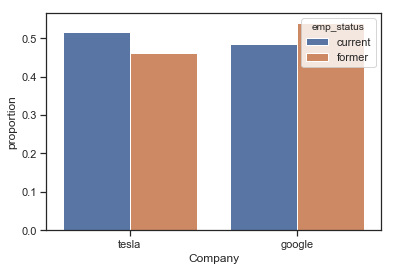

In [48]:
# Barplot - Percentage of reviews by current/former empployees

# Code sournce
# https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot

x, y, hue = "Company", "proportion", "emp_status"
# hue_order = ["Male", "Female"]

(df_comp[x]
 .groupby(df_comp[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue));

#### Explore rating variable

In [49]:
# Look at Rating Summary for Google
df_google['rating'].describe()

count    1329.000000
mean        4.221971
std         0.999065
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

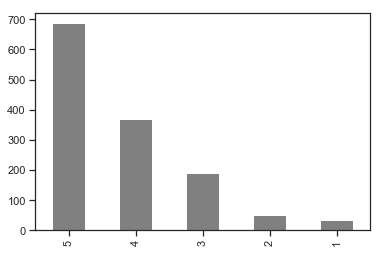

In [50]:
# Rating Frequency Bar Plot Google
df_google['rating'].value_counts().plot.bar(color='Gray');

In [51]:
# Look at Rating Summary for Tesla
df_tesla['rating'].describe()

count    1235.000000
mean        3.587854
std         1.277285
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

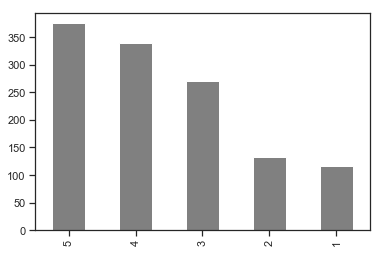

In [52]:
# Rating Frequency Bar Plot Google
df_tesla['rating'].value_counts().plot.bar(color='Gray');

#### Explore state variable

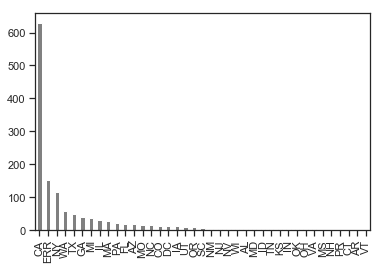

In [53]:
# State Frequency Bar Plot Google
df_google['state'].value_counts().plot.bar(color='Gray');

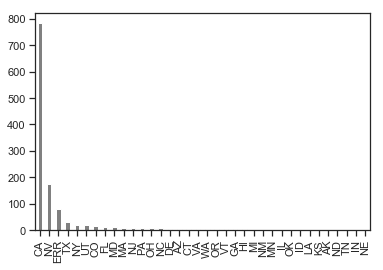

In [55]:
# State Frequency Bar Plot Google
df_tesla['state'].value_counts().plot.bar(color='Gray');

#### TF-IDF


In [56]:
# Combine title and reviews to clean for each review
google_review_text = df_google["title"] + ' ' + df_google["reviews"]
tesla_review_text = df_tesla["title"] + ' ' + df_tesla["reviews"]

In [57]:
# Take a closer look at combine review text
google_review_text[1]

'Google is great Bon Apeptit isn’t so great! Google is a great company and the googler were awesome, knowledgeable and open to teaching. It was the company I was contacted with Bon Apeptit that was terrible the management was u professional much like being on highschool. Not much room for advancement unless you were related to someone that worked there. I worked there for a year only revived a 2% increase in my raise so after a year in a half I was at 15.30. I felt like I was treated poorly by management there. As well as my health and safety while working was put at risk'

In [58]:
tesla_review_text[1]

"Looks good on the resume Tesla asks if you're okay with overtime but you don't realize you're giving up all your personal time. As a service advisor, you start your day writing tickets and interacting with customers. Throughout the day, you need to keep up with updating customers three times a day while stuck on the drive. Management sets expectations that aren't feasible and focus on the customer service index that you don't always have control over (the customers not filling out the survey or deleting them). It was difficult to balance the work load and a personal life with the amount of time it takes to keep customers in the loop."

In [59]:
# Function to clean text

# Parts of code from Week 3 and Week 6 Solutions
# Regis Text Analytics Class - Dr. Nathan George

def preprocess_text(text_docs):
   
    # remove punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    docs = [str(d).translate(table) for d in text_docs]
    # replace newlines with spaces
    docs = [re.sub('[\r\n]+', ' ', d) for d in docs]
    # replace website links with space -- want to do this before digits
    docs = [re.sub('https[\w]*', ' ', d) for d in docs]
    # replace digits with space
    docs = [re.sub('\d', ' ', d) for d in docs]
    # relpace multiple spaces with one
    docs = [re.sub('\s\s+', ' ', d) for d in docs]
    
    
    # process with spacy
    spacy_docs = [nlp(d) for d in docs]
    lemmatized_docs = []
    
    # keep the word if it's a pronoun, otherwise use the lemma
    lemmas = [[w.lemma_ if w.lemma_ != '-PRON-'
                   else w.lower_
                   for w in d if w.lower_ not in en_stopwords]
              for d in spacy_docs]
    
    
    pos = [[w.pos_ for w in d if w.lower_ not in en_stopwords] for d in spacy_docs]
    flat_lemmas = [i for l in lemmas for i in l]
    flat_pos = [i for p in pos for i in p]
    df = pd.DataFrame({'word': flat_lemmas, 'pos': flat_pos})
    
    lemmatized_docs = [' '.join(l) for l in lemmas]
    
    return lemmatized_docs, df

In [60]:
# Run preprocess_text for reviews
cln_review_google, df_pos_google = preprocess_text(google_review_text)
cln_review_tesla, df_pos_tesla = preprocess_text(tesla_review_text)

In [61]:
# Take a closer look at cleaned review
cln_review_google[1]

'great bon apeptit not great great company googler awesome knowledgeable open teach company contact bon apeptit terrible management u professional much like highschool much room advancement unless relate someone work work year revive increase raise year half feel like treat poorly management well health safety work put risk'

In [62]:
cln_review_tesla[1]

'look good resume ask okay overtime not realize give personal time service advisor start day write ticket interact customer throughout day need keep update customer three time day stick drive management set expectation not feasible focus customer service index not always control customer fill survey delete difficult balance load personal life amount time take keep customer loop'

In [63]:
# Create lists of grouped words - part of speech, word

# Code Source
# From Text Analytics Week 3 - Dr. Nathan George

words_google = list(df_pos_google.groupby('word'))
words_tesla = list(df_pos_tesla.groupby('word'))

In [65]:
# Gets value counts of words - word, pos, count

# From Text Analytics Week 3 - Dr. Nathan George

all_cnts_google = {}
for w, w_df in words_google:
    all_cnts_google[w] = w_df['pos'].value_counts()
    
all_cnts_tesla = {}
for w, w_df in words_tesla:
    all_cnts_tesla[w] = w_df['pos'].value_counts()

In [69]:
# Total up nouns and verbs

# From Text Analytics Week 3 - Dr. Nathan George

nouns_google, verbs_google = {}, {}
for w in all_cnts_google:
    if 'NOUN' in all_cnts_google[w].keys():
        nouns_google[w] = all_cnts_google[w]['NOUN']
    
    if 'VERB' in all_cnts_google[w].keys():
        verbs_google[w] = all_cnts_google[w]['VERB']
        
        
nouns_tesla, verbs_tesla = {}, {}
for w in all_cnts_tesla:
    if 'NOUN' in all_cnts_tesla[w].keys():
        nouns_tesla[w] = all_cnts_tesla[w]['NOUN']
    
    if 'VERB' in all_cnts_tesla[w].keys():
        verbs_tesla[w] = all_cnts_tesla[w]['VERB']

In [70]:
# Report out top 10 nouns and verbs per company

# Code Source from Week 3 Text Analytics - Dr. Nathan George
# https://stackoverflow.com/questions/613183/how-to-sort-a-dictionary-by-value

# Sorting most nouns/verbs to the least
top_nouns_google = sorted(nouns_google, key=nouns_google.get, reverse=True)
top_noun_counts_google = [nouns_google[n] for n in top_nouns_google]
top_verbs_google = sorted(verbs_google, key=verbs_google.get, reverse=True)
top_verb_counts_google = [verbs_google[v] for v in top_verbs_google]

top_nouns_tesla = sorted(nouns_tesla, key=nouns_tesla.get, reverse=True)
top_noun_counts_tesla = [nouns_tesla[n] for n in top_nouns_tesla]
top_verbs_tesla = sorted(verbs_tesla, key=verbs_tesla.get, reverse=True)
top_verb_counts_tesla = [verbs_tesla[v] for v in top_verbs_tesla]

print('top 10 Google nouns:\n')
for n, c in zip(top_nouns_google[:10], top_noun_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Google verbs:\n')
for n, c in zip(top_verbs_google[:10], top_verb_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('top 10 Tesla nouns:\n')
for n, c in zip(top_nouns_tesla[:10], top_noun_counts_tesla[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Tesla verbs:\n')
for n, c in zip(top_verbs_tesla[:10], top_verb_counts_tesla[:10]):
    print(n, '(' + str(c) + ' times)')

top 10 Google nouns:

job (531 times)
place (512 times)
company (447 times)
people (424 times)
day (296 times)
time (292 times)
environment (282 times)
team (278 times)
lot (253 times)
part (244 times)

top 10 Google verbs:

work (501 times)
learn (306 times)
get (279 times)
make (203 times)
would (203 times)
enjoy (131 times)
go (122 times)
love (117 times)
need (103 times)
help (100 times)
top 10 Tesla nouns:

company (612 times)
job (538 times)
place (466 times)
people (375 times)
day (372 times)
hour (317 times)
time (303 times)
management (300 times)
environment (256 times)
lot (248 times)

top 10 Tesla verbs:

work (478 times)
get (337 times)
learn (264 times)
make (262 times)
would (225 times)
go (196 times)
love (137 times)
need (131 times)
want (119 times)
give (111 times)


In [72]:
# Get top n-grams from the reviews

# From Text Analytics Week 3 - Dr. Nathan George

def get_top_grams_google(docs, n=2, top=10):
    
    v_google = CountVectorizer(ngram_range=(n, n))
    grams_google = v_google.fit_transform(cln_review_google)
    # convert to array and flatten to avoid weird indexing
    gram_sum_google = np.array(np.sum(grams_google, axis=0)).flatten()
    gram_dict_google = {i: v for v, i in v_google.vocabulary_.items()}  # dictionary of index: word
    top_grams_google = gram_sum_google.argsort()[::-1]
    for i in top_grams_google[:top]:
        print('"' + gram_dict_google[i] + '" shows up', gram_sum_google[i], 'times')
    
    return [gram_dict_google[i] for i in top_grams_google], gram_sum_google[top_grams_google]

In [73]:
# Report out top 10 for 2,3, and 4 grams

# From Text Analytics Week 3 - Dr. Nathan George

ngrams_google, ngram_counts_google = {}, {}
for n in [2, 3, 4]:
    print('top 10', str(n) + '-grams:\n')
    ngrams_google[n], ngram_counts_google[n] = get_top_grams_google(cln_review_google, n=n)
    print('\n')

top 10 2-grams:

"great place" shows up 182 times
"part job" shows up 116 times
"great company" shows up 99 times
"fun place" shows up 93 times
"typical day" shows up 83 times
"hard part" shows up 82 times
"productive fun" shows up 58 times
"good place" shows up 58 times
"enjoyable part" shows up 57 times
"learn lot" shows up 53 times


top 10 3-grams:

"hard part job" shows up 55 times
"enjoyable part job" shows up 35 times
"great place great" shows up 25 times
"productive fun place" shows up 24 times
"great company great" shows up 19 times
"productive fun workplace" shows up 16 times
"full time employee" shows up 15 times
"get job do" shows up 14 times
"typical day consist" shows up 13 times
"company great company" shows up 13 times


top 10 4-grams:

"great company great company" shows up 8 times
"great place great place" shows up 6 times
"time want whatev clothe" shows up 4 times
"great place great company" shows up 4 times
"fun workplace ping pong" shows up 4 times
"workplace ping

In [75]:
def get_top_grams_tesla(docs, n=2, top=10):
    
    v_tesla = CountVectorizer(ngram_range=(n, n))
    grams_tesla = v_tesla.fit_transform(cln_review_tesla)
    # convert to array and flatten to avoid weird indexing
    gram_sum_tesla = np.array(np.sum(grams_tesla, axis=0)).flatten()
    gram_dict_tesla = {i: v for v, i in v_tesla.vocabulary_.items()}  # dictionary of index: word
    top_grams_tesla = gram_sum_tesla.argsort()[::-1]
    for i in top_grams_tesla[:top]:
        print('"' + gram_dict_tesla[i] + '" shows up', gram_sum_tesla[i], 'times')
    
    return [gram_dict_tesla[i] for i in top_grams_tesla], gram_sum_tesla[top_grams_tesla]

In [76]:
ngrams_tesla, ngram_counts_tesla = {}, {}
for n in [2, 3, 4]:
    print('top 20', str(n) + '-grams:\n')
    ngrams_tesla[n], ngram_counts_tesla[n] = get_top_grams_tesla(cln_review_tesla, n=n)
    print('\n')

top 20 2-grams:

"great place" shows up 132 times
"fast pace" shows up 97 times
"part job" shows up 97 times
"long hour" shows up 87 times
"good place" shows up 71 times
"great company" shows up 69 times
"fast paced" shows up 64 times
"hard part" shows up 63 times
"typical day" shows up 56 times
"fun place" shows up 56 times


top 20 3-grams:

"hard part job" shows up 49 times
"enjoyable part job" shows up 32 times
"fast paced environment" shows up 22 times
"great place great" shows up 12 times
"great company great" shows up 11 times
"productive fun place" shows up 11 times
"productive fun workplace" shows up 11 times
"place great place" shows up 9 times
"world transition sustainable" shows up 8 times
"get job do" shows up 8 times


top 20 4-grams:

"world transition sustainable energy" shows up 6 times
"hour day day week" shows up 6 times
"great place great place" shows up 6 times
"accelerate world transition sustainable" shows up 6 times
"hard part job would" shows up 5 times
"great 

In [136]:
# TFIDF - fit/transform

# min_df=3 ignores terms occuring in less than 3 documents
# max_features for feature reduction - 100

#Code from Week 4 Solution - Regis Text Analytics Class - Dr. Nathan George

# Instantiate tfidf vectorizer and fit_transform
tfidf_vectorizer_google = TfidfVectorizer(min_df=3,ngram_range=(1,1))
train_tfidf_vectors_google = tfidf_vectorizer_google.fit_transform(cln_review_google)

tfidf_vectorizer_tesla = TfidfVectorizer(max_features=250,min_df=3,ngram_range=(1,1))
train_tfidf_vectors_tesla = tfidf_vectorizer_tesla.fit_transform(cln_review_tesla)

In [137]:
train_tfidf_vectors_google.shape

(1329, 1533)

In [134]:
train_tfidf_vectors_tesla.shape

(1235, 250)

In [85]:
# Instantiate wordcloud and set size
wc = wordcloud.WordCloud(width=800, height=400)

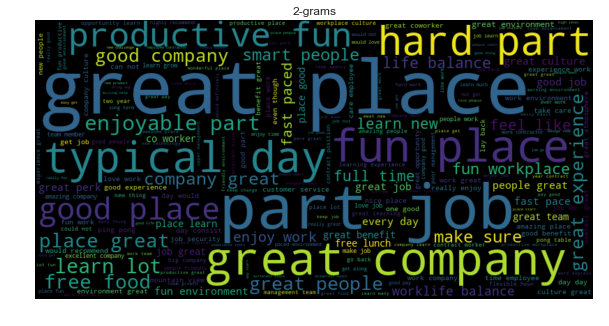

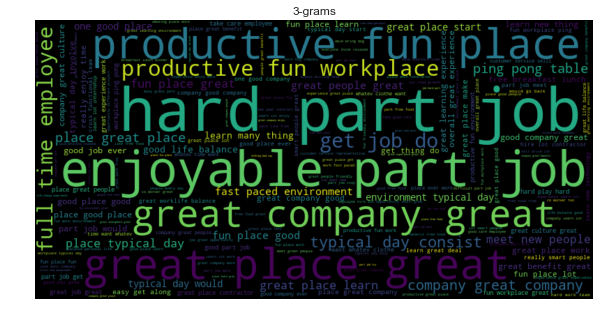

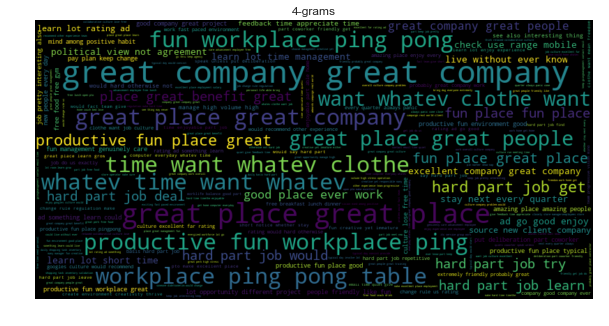

In [86]:
# Wordcloud for 2,3,4 grams

# Week 3 Text Analytics - Dr. Nathan George

for n in [2, 3, 4]:
    f = wc.generate_from_frequencies(frequencies={w: i for w, i in zip(ngrams_google[n], ngram_counts_google[n])})
    fig = plt.figure(figsize=(10, 10))
    _ = plt.imshow(f, interpolation='bilinear')
    _ = plt.axis("off")  # assign result to a dummy variable so it doesn't show anything
    _ = plt.title(str(n) + '-grams')

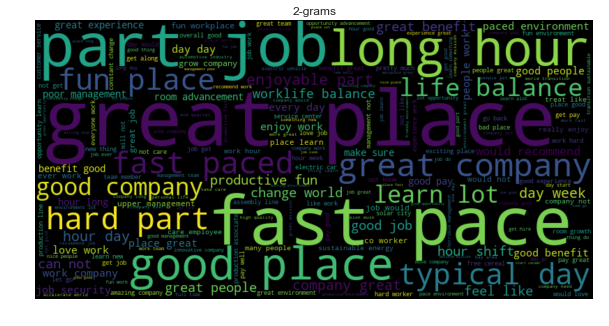

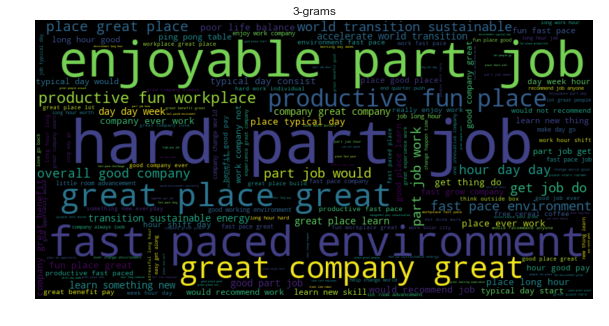

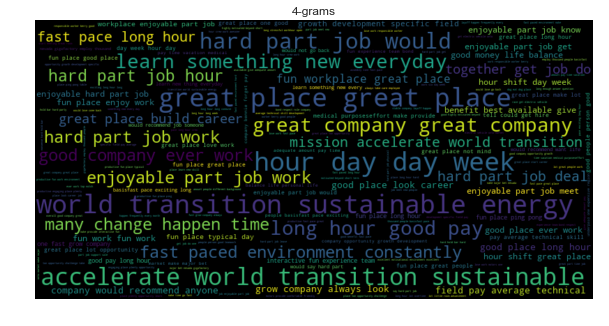

In [87]:
# Week 3 Text Analytics
for n in [2, 3, 4]:
    f = wc.generate_from_frequencies(frequencies={w: i for w, i in zip(ngrams_tesla[n], ngram_counts_tesla[n])})
    fig = plt.figure(figsize=(10, 10))
    _ = plt.imshow(f, interpolation='bilinear')
    _ = plt.axis("off")  # assign result to a dummy variable so it doesn't show anything
    _ = plt.title(str(n) + '-grams')

## Time Series

In [88]:
# Value counts by date

# Code Source
# https://stackoverflow.com/questions/22391433/
# count-the-frequency-that-a-value-occurs-in-a-dataframe-column

df_date_count_google = df_google['date'].value_counts()
df_date_count_tesla = df_tesla['date'].value_counts()


In [89]:
# Save as a dataframe
df_date_google = pd.DataFrame(df_date_count_google)
df_date_tesla = pd.DataFrame(df_date_count_tesla)

In [90]:
df_date_google.head()

,date
2018-06-27,6
2017-08-31,6
2018-01-18,6
2018-01-25,5
2018-10-22,5


In [91]:
# Getting into format for time series plot
# reset and name index, rename columns

# Code Source
# https://stackoverflow.com/questions/26097916/
# convert-pandas-series-to-dataframe

df_count_google = df_date_google.date.to_frame().reset_index()
df_count_google = df_count_google.rename(columns= {'index': 'date', 'date': 'count' })
df_count_google.index.name = 'index'

df_count_tesla = df_date_tesla.date.to_frame().reset_index()
df_count_tesla = df_count_tesla.rename(columns= {'index': 'date', 'date': 'count' })
df_count_tesla.index.name = 'index'


In [92]:
df_count_google.head(2)

,date,count
index,,
0,2018-06-27,6
1,2017-08-31,6


In [93]:
# Set date as the index for time series plots

# Code Source - # https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_count_google.set_index('date', inplace=True)
df_count_tesla.set_index('date', inplace=True)

In [94]:
df_count_google.head(2)

,count
date,
2018-06-27,6
2017-08-31,6


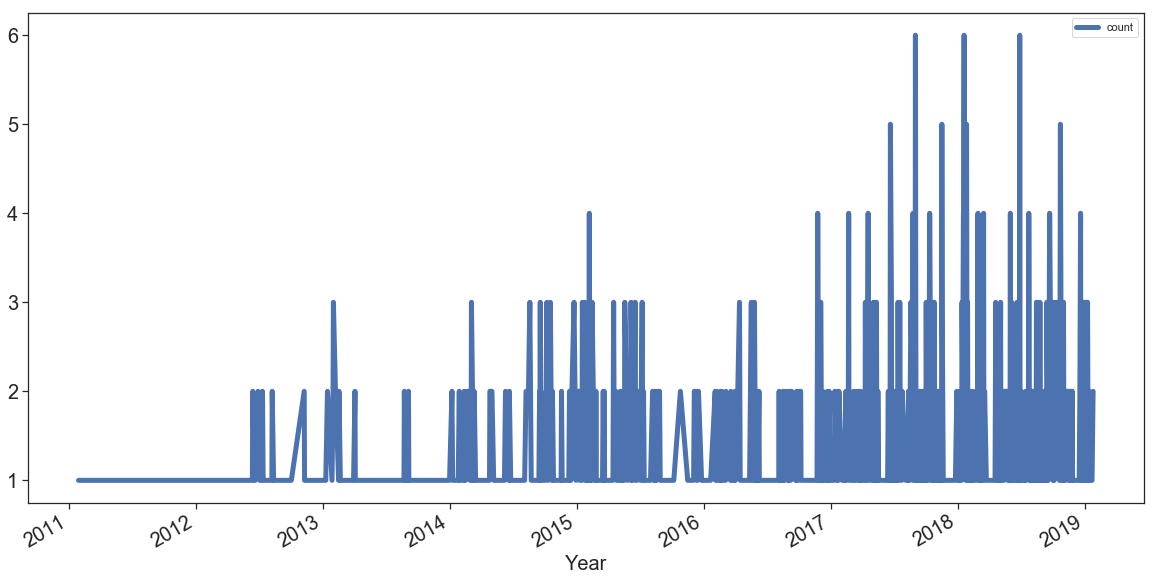

In [96]:
# Set date as the index for time series plots

# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_count_google.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);


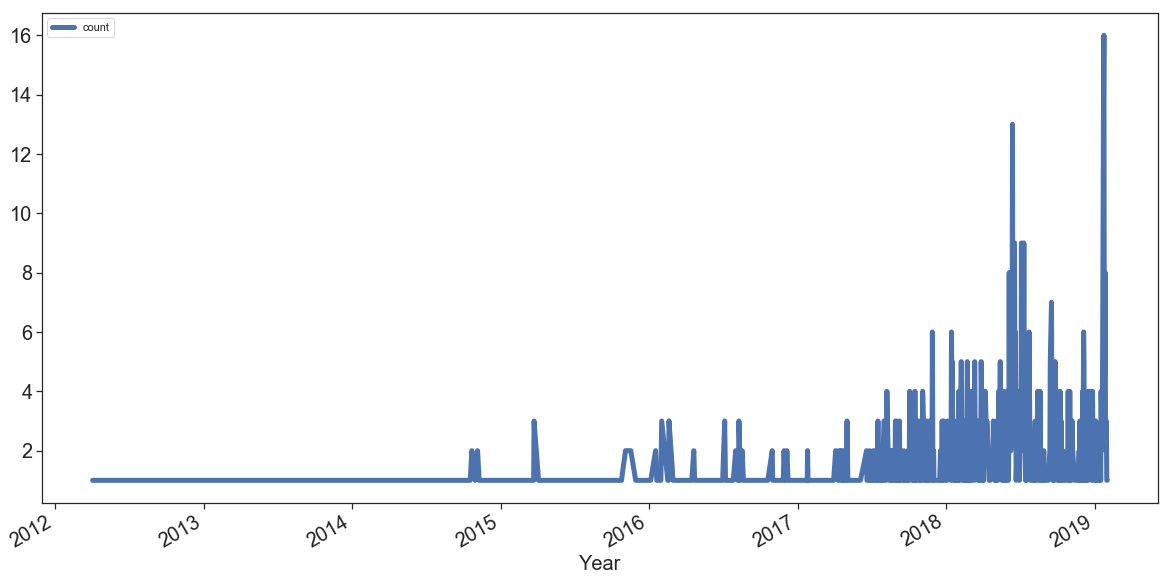

In [95]:
# Plot time series tesla
df_count_tesla.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);

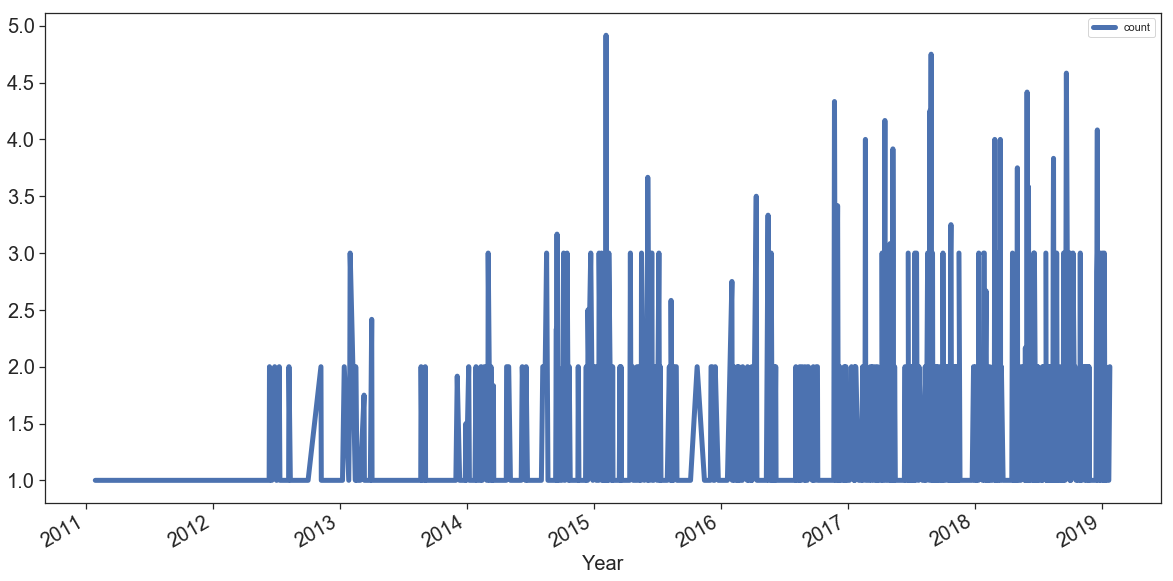

In [97]:
# Plot time series rolling mean google

# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

df_count_google.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

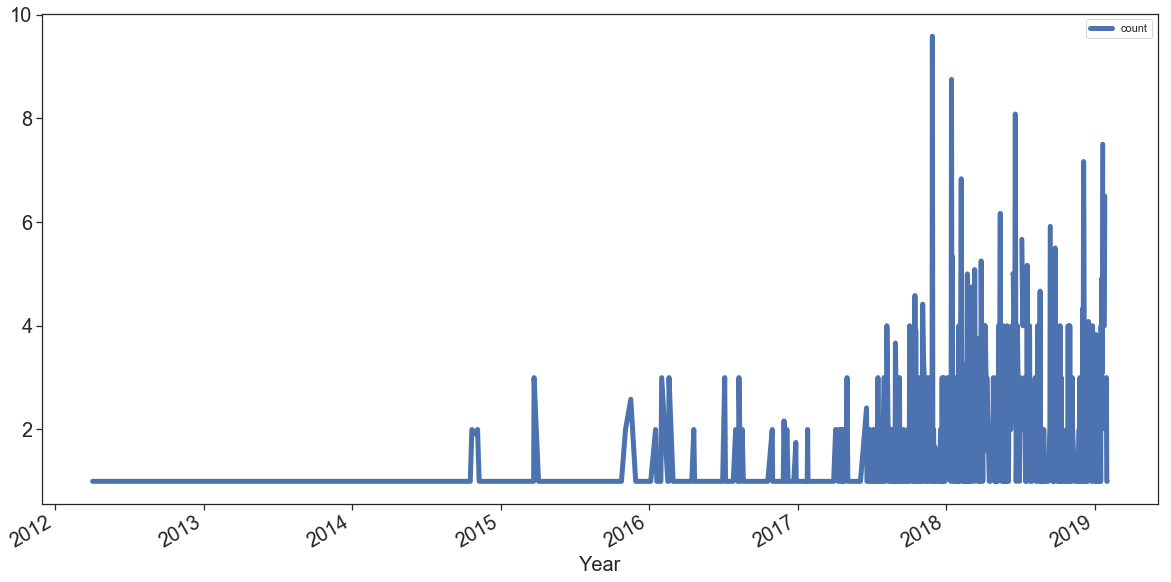

In [98]:
# Plot time series rolling mean tesla
df_count_tesla.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [99]:
# Look at day of week reviews were submitted

# Covert to day of the week (Monday=0, Sunday=6)

# Code Source
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html

df_google_day_of_week = df_comp['date'].dt.dayofweek

In [101]:
# Case statement to match integer to day of week text

# Code Source
# https://data-flair.training/blogs/python-switch-case/

def week(i):
    switcher={
        0:'Monday',
        1:'Tuesday',
        2:'Wednesday',
        3:'Thursday',
        4:'Friday',
        5:'Saturday',
        6:'Sunday'
             }
    return switcher.get(i,"Invalid day of week")

In [104]:
# Creating file to plot day of week by company comparison

# Call function - add new variable to df_comp
df_comp['dayofweek'] = np.array([week(i) for i in df_google_day_of_week[0:]])

In [105]:
# Change data type for categorical variables
df_comp['dayofweek'] = df_comp['dayofweek'].astype('category')

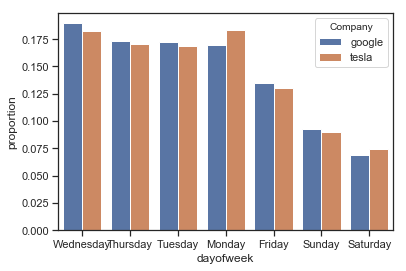

In [106]:
# Barplot - review day of week by company
# Code Source
# https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot

x, y, hue = "dayofweek", "proportion", "Company"

(df_comp[x]
 .groupby(df_comp[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data",), x=x, y=y, hue=hue,));


## Sentiment Analysis

In [109]:
# Grab reviews variable

# Code source:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

df_google_cln_rev = pd.DataFrame(data=cln_review_google, columns=['Reviews'])
df_tesla_cln_rev = pd.DataFrame(data=cln_review_tesla, columns=['Reviews'])

In [110]:
# Using textblob for sentiment,
# assign 1, 0, -1 based on polarity

# Code source:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

def analize_sentiment(Reviews):
   
    analysis = TextBlob(Reviews)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [111]:
# Call function and add SA to dataframe

# Code source
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

df_google['SA'] = np.array([analize_sentiment(Reviews) for Reviews in df_google_cln_rev['Reviews']])
df_tesla['SA'] = np.array([analize_sentiment(Reviews) for Reviews in df_tesla_cln_rev['Reviews']])

In [113]:
# Save out polarity to dataframe as well

def analize_polarity(Reviews):
   
    analysis = TextBlob(Reviews)
    return analysis.sentiment.polarity

In [114]:
df_google['Polarity'] = np.array([analize_polarity(Reviews) for Reviews in df_google_cln_rev['Reviews']])
df_tesla['Polarity'] = np.array([analize_polarity(Reviews) for Reviews in df_tesla_cln_rev['Reviews']])

In [115]:
df_google.head(2)

,title,date,rating,reviews,job_title,emp_status,state,latitude,longitude,Company,SA,Polarity
0,Awesome,2018-01-17,5,Awesome stuff at google if I had to rate it fr...,Camp Counselor,former,MA,42.407211,-71.382437,google,1,0.655952
1,Google is great Bon Apeptit isn’t so great!,2018-08-24,5,Google is a great company and the googler were...,Micro kitchen attendant,former,CA,36.778261,-119.417932,google,1,0.103030


In [116]:
df_tesla.head(2)

,title,date,rating,reviews,job_title,emp_status,state,latitude,longitude,Company,SA,Polarity
0,Stressful,2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...,PV Design Engineer II,current,MA,42.407211,-71.382437,tesla,1,0.009921
1,Looks good on the resume,2019-01-16,3,Tesla asks if you're okay with overtime but yo...,Service Advisor,former,CA,36.778261,-119.417932,tesla,1,0.140000


In [117]:
# Look at sentiment compared to rating

# Code Source
# https://pbpython.com/pandas-crosstab.html

pd.crosstab(df_google.rating, df_google.SA)

SA,-1,0,1
rating,,,
1,14,3,18
2,8,2,40
3,17,6,165
4,22,8,338
5,11,12,665


In [118]:
pd.crosstab(df_tesla.rating, df_tesla.SA)

SA,-1,0,1
rating,,,
1,57,4,55
2,36,7,90
3,39,7,225
4,18,4,317
5,15,5,356


In [119]:
# Look at some reviews with positive sentiment and give a rating of 1
# https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

df_tesla[['reviews','Polarity']].loc[(df_tesla['rating'] == 1) & (df_tesla['SA'] == 1)].head(5)

,reviews,Polarity
16,Tesla is a very fast paced job were what you d...,0.070986
111,"Right so, I've been working here just over a y...",0.113189
141,The culture of working with this company is th...,0.175000
155,Tesla was a dog eat dog place with very little...,0.203125
160,Every day is pretty much the same. you come in...,0.225000


## Geo

In [ ]:
# Geo - https://www.datacamp.com/community/tutorials/geospatial-data-python
# Avg sentiment/rating by location - map as a visual - folium - interactive

In [121]:
# Create files with state/sentiment mean and state/rating mean

# Code Source
# https://towardsdatascience.com/pandas-tips-and-tricks-33bcc8a40bb9

df_google_state_SA = df_google.groupby('state')['SA'].mean()
df_tesla_state_SA = df_tesla.groupby('state')['SA'].mean()

df_google_state_rating = df_google.groupby('state')['rating'].mean()
df_tesla_state_rating = df_tesla.groupby('state')['rating'].mean()

In [122]:
# Make them dataframes 

df_google_state_SA = pd.DataFrame(df_google_state_SA)
df_tesla_state_SA = pd.DataFrame(df_tesla_state_SA)

df_google_state_rating = pd.DataFrame(df_google_state_rating)
df_tesla_state_rating = pd.DataFrame(df_tesla_state_rating)

In [123]:
# Reset indexes

df_google_state_SA.reset_index(inplace=True)
df_tesla_state_SA.reset_index(inplace=True)

df_google_state_rating.reset_index(inplace=True)
df_tesla_state_rating.reset_index(inplace=True)

In [124]:
# Remove the ERR states

# https://stackoverflow.com/questions/34397982/pandas-dataframe-access-multiple-items-with-not-equal-to
notERR_google_SA = df_google_state_SA[df_google_state_SA['state'] != 'ERR']
notERR_tesla_SA = df_tesla_state_SA[df_tesla_state_SA['state'] != 'ERR']

# https://stackoverflow.com/questions/34397982/pandas-dataframe-access-multiple-items-with-not-equal-to
notERR_google_rating = df_google_state_rating[df_google_state_rating['state'] != 'ERR']
notERR_tesla_rating = df_tesla_state_rating[df_tesla_state_rating['state'] != 'ERR']

In [125]:
# Looks good!
notERR_google_SA.head()

,state,SA
0,AL,0.666667
1,AR,1.000000
2,AZ,0.722222
3,CA,0.888712
4,CO,1.000000


In [126]:
# Folium choropleth of average sentiment by state - Google

# Code sources
# https://medium.com/@austinlasseter/using-folium-to-generate-a-simple-map-of-your-pandas-data-87ddc5d55f8d
# https://python-graph-gallery.com/292-choropleth-map-with-folium/
# https://github.com/bradtraversy/python_folium_example/edit/master/data/us-states.json

map = folium.Map(location=[48, -102], zoom_start=3)

#mac
state_geo = os.path.join('/Users/christiandavies/Desktop/data_pract_1/Project', 'us-states.json')

# windows 
# state_geo = os.path.join(r"C:\Users\Czdavies\Desktop\DS_prac_1\project", 'us-states.json')

map.choropleth(geo_data=state_geo, data=notERR_google_SA,
             columns=['state', 'SA'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [127]:
# Folium choropleth of average rating by state - Google

map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_google_rating,
             columns=['state', 'rating'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [128]:
# Folium choropleth of average sentiment by state - Tesla


map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_tesla_SA,
             columns=['state', 'SA'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [129]:
# Folium choropleth of average rating by state - Tesla

map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_tesla_rating,
             columns=['state', 'rating'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Unsupervised Learning - Clustering

In [ ]:
# Code Source
# http://brandonrose.org/clustering 

# Cosine Similarity Distance measurement - doc compared to all other docs, remove, creating too may dimensions

# dist_google = 1 - cosine_similarity(train_tfidf_vectors_google)
# dist_tesla = 1 - cosine_similarity(train_tfidf_vectors_tesla)

In [ ]:
# Convert additional features for machine learning - think these are not adding value, remove

# df_google_emp_status = pd.get_dummies(df_google['emp_status'])
# df_tesla_emp_status = pd.get_dummies(df_tesla['emp_status'])

# df_google_state = pd.get_dummies(df_google['state'])
# df_tesla_state = pd.get_dummies(df_tesla['state'])


In [138]:
# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas

df_tfidf_google = pd.DataFrame(train_tfidf_vectors_google.toarray())
df_tfidf_tesla = pd.DataFrame(train_tfidf_vectors_google.toarray())

In [ ]:
# df_med_google = pd.concat([df_google.rating, df_google.SA, df_google.Polarity, df_tfidf_google], axis=1, ignore_index=True) 
# df_med_google = df_med_google.rename(columns= {0: 'rating', 1: 'SA', 2: 'polarity' })


# df_med_tesla = pd.concat([df_tesla.rating, df_tesla.SA, df_tesla.Polarity, df_tfidf_tesla], axis=1, ignore_index=True) 
# df_med_tesla = df_med_tesla.rename(columns= {0: 'rating', 1: 'SA', 2: 'polarity'})




In [ ]:
# df_med_google.head()

In [139]:
google_matrix = np.asarray(df_tfidf_google)

In [150]:

# Code source:
# https://github.com/chrisjmccormick/LSA_Classification/blob/master/inspect_LSA.py
# https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False, norm='l1'))
x_train_lsa = lsa.fit_transform(google_matrix)
print('LSA output shape:', x_train_lsa.shape)
explained_variance = svd.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))

LSA output shape: (1329, 100)
Sum of explained variance ratio: 39%


In [151]:
# Code source
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1cluster__visualizer__multidim.html
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
sample = read_sample(FCPS_SAMPLES.SAMPLE_HEPTA)
from pyclustering.cluster import cluster_visualizer_multidim

In [ ]:
search_instance = silhouette_ksearch(x_train_lsa, 2,100, algorithm=silhouette_ksearch_type.KMEDOIDS).process()
amount = search_instance.get_amount()
scores = search_instance.get_scores()
print("Scores: '%s'" % str(scores))

In [144]:
# Get index of max score - identify # of clusters

# Code source
# https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary

import operator
max(scores.items(), key=operator.itemgetter(1))[0]

3

In [ ]:
# tolist needed for k-medoids
google_list = df_med_google.values.tolist()
tesla_list = df_med_tesla.values.tolist()

In [ ]:
# https://github.com/annoviko/pyclustering/blob/master/pyclustering/cluster/ema.py
# https://github.com/annoviko/pyclustering/issues/366
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1kmedoids_1_1kmedoids.html
# https://github.com/letiantian/kmedoids

# set random initial medoids
initial_medoids = list(range(0,4))
# create instance of K-Medoids algorithm
kmedoids_instance = kmedoids(google_list, initial_medoids)
# kmedoids_instance = kmedoids(df_med_google.as_matrix(), initial_medoids)
# run cluster analysis and obtain results
kmedoids_instance.process();
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids();

# Only 2 clusters were extracted in version without fix (now 3)
print("Amount of clusters:", len(clusters));
for cluster in clusters:
    print("Cluster length:", len(cluster));

In [ ]:
# Code from Dr. George
cluster_number = []
indices = []
for i, c in enumerate(clusters):
    cluster_number.extend([i] * len(c))
    indices.extend(c)

df = pd.DataFrame({'cluster': cluster_number, 'index': indices})

In [ ]:
df.head(10)

In [ ]:
df.set_index('index', inplace=True)

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df_med_google['cluster'] = df['cluster']

In [ ]:
df_med_google.head()

In [ ]:
terms_google = tfidf_vectorizer_google.get_feature_names()

In [ ]:
# https://stackoverflow.com/questions/30328646/python-pandas-group-by-in-group-by-and-average
df_med_google.groupby(['cluster']).mean()

In [ ]:
for i in range(4):
    print("Cluster %d:" % i),
    for ind in order_centroids_google[i, :10]:
        print(' %s' % terms_google[ind]),
    print

In [ ]:
df_cluster_top = df_med_google.drop(columns=['rating', 'SA', 'polarity'])

In [ ]:
df_cluster_top = df_cluster_top.T

In [ ]:
df_cluster_top

In [ ]:
top_verbs_tesla = sorted(verbs_tesla, key=verbs_tesla.get, reverse=True)
top_verb_counts_tesla = [verbs_tesla[v] for v in top_verbs_tesla]

print('top 10 Google nouns:\n')
for n, c in zip(top_nouns_google[:10], top_noun_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')

In [ ]:
# Code Source
# https://pythonprogramminglanguage.com/kmeans-text-clustering/

# Google

print("Top terms per Google cluster:")
order_centroids_google = kmedoids_instance.cluster_centers_.argsort()[:, ::-1]
terms_google = tfidf_vectorizer_google.get_feature_names()
for i in range(true_k_google):
    print("Cluster %d:" % i),
    for ind in order_centroids_google[i, :10]:
        print(' %s' % terms_google[ind]),
    print

## LDA/NMF

In [ ]:
# Code Source
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_
# nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
# Fit the NMF model 1 

n_components = 10
n_top_words = 10

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(train_tfidf_vectors_google)

tfidf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

In [ ]:
# Fit the NMF model 2 
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_tfidf_vectors_google)

tfidf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

In [ ]:
# Fit the LDA model 1 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_tfidf_vectors_google)

tf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
# Fit the NMF model 1 

n_components = 10
n_top_words = 10

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(train_tfidf_vectors_tesla)

tfidf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

In [ ]:
# Fit the NMF model 2 
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_tfidf_vectors_tesla)

tfidf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

In [ ]:
# Fit the LDA model 1 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_tfidf_vectors_tesla)

tf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
# LSA or LDA easier in R - save tfidf in python - load into R and run LDA and LSA.
# Graphlab - nice library for topic models, try first in python - activate license

 ### parameter tuning LDA NMF ABOVE

In [ ]:
# Topic Modeling - lda, lsa - useful - take action
# Words - make pick up some words that are not in sentiment - extract the most popular words

# densify tfidf vector - take top 100 words - use min freq to get certain number of dimensions - max features 
# - tfidf documentation

# way to look at most important words - look this up - forest methods.  random forest - feature importance